# MNIST

Obiettivo: costruire un modello che sia in grado di riconoscere carattere numerico manoscritto.

paragonare modello dl senza preprocessing e modello costruito dopo preprocessing

## Step

Al fine di diminuire il numero di neuroni della rete e migliorare le prestazioni, si effettua del preprocessing.

- Importing data
- Preprocessing
  1. eliminazione rumore (filtro mediano)
  1. uniforming thickness
  1. resizing & centering
  1. fixing discontinuity (reconstructing ink hole)
  1. normalizing
- model

Cominciamo importando le librerie necessarie per il corretto funzionamento del codice (tensorflow, keras, matplotlib)

In [1]:
%%capture
import os
import pandas as pd
import cv2
import tensorflow.keras as keras
import tensorflow as tf
import mnist
import numpy as np
import matplotlib.pyplot as plt
from   tensorflow.keras.models import Sequential
from   tensorflow.keras.layers import Dense

2023-03-26 16:14:56.014502: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## No pre-processing
Addestro modello senza effettuare preprocessing

In [31]:
# loading data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data(path = "mnist.npz")

# undestand data dimensions
print("Data dimensions:\n")
print("x_lrn:",x_train.shape)
print("x_tst:",x_test.shape)
print("y_lrn:",y_train.shape)
print("y_tst:",y_test.shape)

Data dimensions:

x_lrn: (60000, 28, 28)
x_tst: (10000, 28, 28)
y_lrn: (60000,)
y_tst: (10000,)


Ecco il pattern n. 7
Il valore atteso è:  3


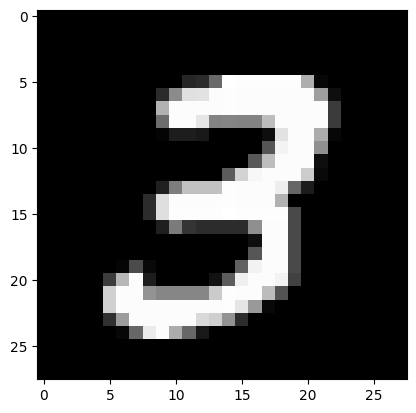

In [3]:
# visualizzo un esempio di pattern
npat = 7
print("Ecco il pattern n.", npat)
print("Il valore atteso è: ", y_train[npat]);

img = x_train[npat];
plt.imshow(img, cmap = 'gray')
plt.show(block = False)

In [4]:
# crea funzione 'recognize_digit' per riconoscere il numero che crei il modello sopra
def recognize_digit(shape, n_epochs, n_categories, x_train, y_train, x_test, y_test, path):

    # rendo categoriche le variabili di output
    y_train = keras.utils.to_categorical(y_train, n_categories)
    y_test = keras.utils.to_categorical(y_test, n_categories)

    # normalizzo usando la funzione di keras
    x_train = keras.utils.normalize(x_train, axis = 1)
    x_test = keras.utils.normalize(x_test, axis = 1)

    # creo il modello
    model = Sequential()

    # flattening
    model.add(keras.layers.Flatten(input_shape = (shape,shape)))

    # aggiungo layer + input
    model.add(Dense(units = 100, activation = 'relu', input_shape = (shape*shape,)))

    # aggiungo uno strato nascosto
    model.add(Dense(units = 2, activation = 'relu'))

    # output layer
    model.add(Dense(units = 10, activation = 'softmax'))

    model.summary()

    # addestro il modello
    model.compile(loss = 'categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs = n_epochs, verbose = 1, validation_data = (x_test, y_test));

    # Salvataggio del modello
    model.save(path)

    # ritorna history
    return history

# crea funzione per visualizzare i risultati
def plot_results(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(5,5))
    plt.subplot(2,1,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')

    # summarize history for loss
    plt.subplot(2,1,2)
    plt.subplots_adjust(hspace = 0.5)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 100)               78500     
                                                                 
 dense_10 (Dense)            (None, 2)                 202       
                                                                 
 dense_11 (Dense)            (None, 10)                30        
                                                                 
Total params: 78,732
Trainable params: 78,732
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1875/1875 [==============================] - 3s 2ms/step - loss: 1.2815 - accuracy: 0.5266 - val_loss: 0.9419 - val_accuracy: 0.6672
Epoch 2/15
1875/1875 [================

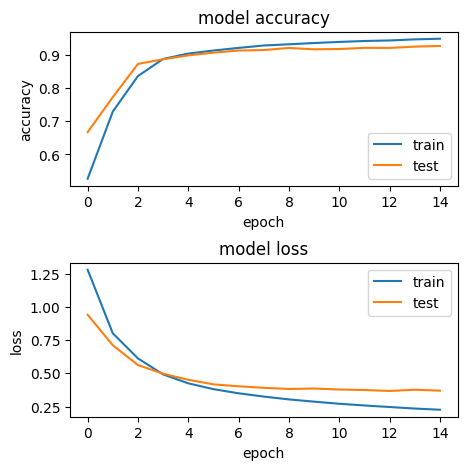

In [32]:
# invoco funzione recognize_digit per creare modello
history = recognize_digit(28, 15, 10, x_train, y_train, x_test, y_test, "4_mnist/models/np.mnist.model.h5")

# invoco funzione per visualizzare i risultati
plot_results(history)

In [33]:
# visualizza tabella history dei risultati con pandas
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,1.281465,0.526600,0.941890,0.6672
1,0.801847,0.729367,0.711990,0.7729
2,0.612750,0.836517,0.562585,0.8731
3,0.492191,0.888050,0.497265,0.8871
4,0.424808,0.904367,0.451531,0.8989
5,0.380883,0.913567,0.417071,0.9071
6,0.349699,0.921500,0.402574,0.9135
7,0.324887,0.928700,0.390874,0.9150
8,0.303523,0.932367,0.382471,0.9213
9,0.286643,0.936200,0.385693,0.9172


## Importo le mie immagini

Creo funzione per salvare tutte le immagini di una cartella in un array e ridimensionarle.

In [34]:
# definisci funzione 'importa_mie_immagini'
def importa_mie_immagini(cartella_immagini, nuova_dimensione):
    # inizializza l'array numpy per contenere tutte le immagini ridimensionate
    immagini = np.empty((0, *nuova_dimensione), dtype=np.uint8)

    # scorri tutti i file nella cartella specificata
    for nome_file in os.listdir(cartella_immagini):
        # carica l'immagine
        percorso_file = os.path.join(cartella_immagini, nome_file)
        img = cv2.imread(percorso_file, cv2.IMREAD_GRAYSCALE)

        # ridimensiona l'immagine
        img_ridimensionata = cv2.resize(img, nuova_dimensione)

        # aggiungi l'immagine all'array numpy
        immagini = np.vstack([immagini, np.expand_dims(img_ridimensionata, axis=0)])

    return immagini

# definisci funzione 'personal_digit_recognizer'
def personal_digit_recognizer(cartella_immagini, nuova_dimensione, model_path):
    # carica le immagini
    immagini = importa_mie_immagini(cartella_immagini, nuova_dimensione)

    # carico modello salvato
    model = keras.models.load_model(model_path)

    # applico modello alle mie immagini
    predictions = model.predict(immagini)

    plt.figure(figsize=(10, 5))
    for i in range(0, immagini.shape[0]):
        plt.subplot(2, 5, i + 1)
        plt.imshow(immagini[i], cmap = 'gray')
        plt.title(np.argmax(predictions[i]))
        plt.axis('off')
    plt.show(block = False)

1/1 [==============================] - 0s 51ms/step


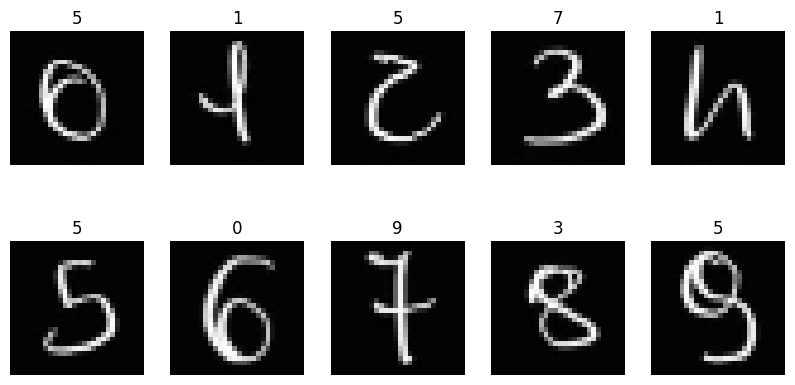

In [35]:
# specifica il percorso della cartella contenente le immagini
cartella_immagini = "4_mnist/img/numbers"

# specifica le dimensioni desiderate
nuova_dimensione = (28, 28)

# applico modello alle mie immagini
personal_digit_recognizer(cartella_immagini, nuova_dimensione, '4_mnist/models/np.mnist.model.h5')

## Pre processing

Visualizziamo un'immagine del dataset di learning (per modificare il numero dell'immagine, modifica il valore della variabile `npat`)

In [9]:
# loading data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data(path = "mnist.npz")

# undestand data dimensions
print("Data dimensions:\n")
print("x_lrn:",x_train.shape)
print("x_tst:",x_test.shape)
print("y_lrn:",y_train.shape)
print("y_tst:",y_test.shape)

Data dimensions:

x_lrn: (60000, 28, 28)
x_tst: (10000, 28, 28)
y_lrn: (60000,)
y_tst: (10000,)


Ecco il pattern n. 7
Il valore atteso è:  3


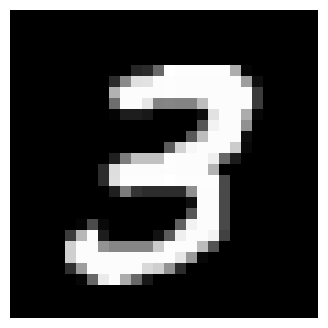

In [10]:
npat = 7
print("Ecco il pattern n.", npat)
print("Il valore atteso è: ", y_train[npat]);

img = x_train[npat];

# definisci funzione 'show_image' con le stesse proprietà del plot sotto
def show_image(img):
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap = 'gray')
    plt.axis('off')
    plt.show(block = False)

# invoco funzione 'show_image'
show_image(img)

Da adesso in poi useremo una variabile temporanea `img` che conterrà l'immagine `x_train[npat]` in modo tale da non lavorare con l'intero array di immagini.

### Reducing noise

L'idea è quella di applicare un filtro mediano.

Utilizzeremo la libreria `OpenCV` (che importeremo con `import cv2`) dopo averla installata da terminale `pip install opencv-python`

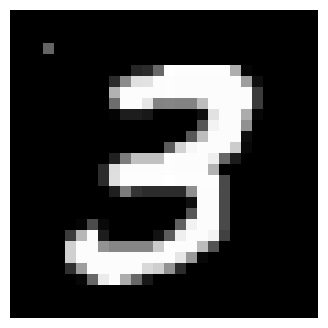

In [11]:
# add noise in pixel 3,3
img[3,3] = 100
x_train[npat,3,3] = 100

# preview
show_image(img)

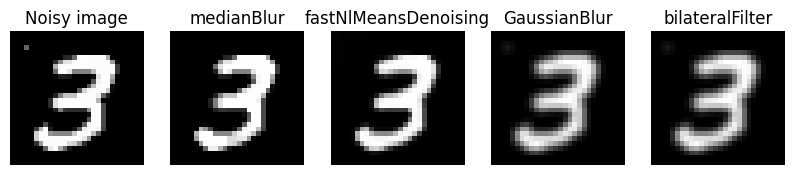

In [12]:
# using csv2 to remove noise
dn0 = cv2.medianBlur(img, 3)
dn1 = cv2.fastNlMeansDenoising(img, h=60, templateWindowSize=3, searchWindowSize=8)
dn2 = cv2.GaussianBlur(img, (3, 3), 1)
dn3 = cv2.bilateralFilter(img, 9, 70, 70)

denoised = [dn0, dn1, dn2, dn2]
titles = ["medianBlur","fastNlMeansDenoising", "GaussianBlur", "bilateralFilter"]

# plotting
plt.figure(figsize=(10, 5))
plt.subplot(1,5,1)
plt.title("Noisy image")
plt.imshow(img, cmap = 'gray')
plt.axis('off')

for i in range(len(denoised)):
    plt.subplot(1,5,i+2)
    plt.title(titles[i])
    plt.imshow(denoised[i], cmap = 'gray')
    plt.axis('off')
    
plt.show()

In [13]:
# scelgo metodo
img = dn0

# check
print("Il rumore è sparito?")
if img[3,3] == 0:
    print("sì, il pixel 3,3 ha valore 0")
else:
    print("no, il pixel 3,3 ha valore", img[3,3])


Il rumore è sparito?
sì, il pixel 3,3 ha valore 0


In [14]:
# definisco funzione 'noise_removal' che applica il filtro di denoising
def noise_removal(img, number):
    # applico filtro di denoising
    oimg = cv2.medianBlur(img, number)
    return oimg

### Fix discontinuity

OpenCV's Closing is reverse of Opening, Dilation followed by Erosion. It is useful in closing small holes inside the foreground objects, or small black points on the object.

`closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)`

dove 

`kernel = np.ones((5,5),np.uint8)`

è la dimensione della finestra di azione del filtro.

[Click here](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html) for more info

Si tratta essenzialmente di un `dilate` seguito da `erode` per "coprire i buchi"

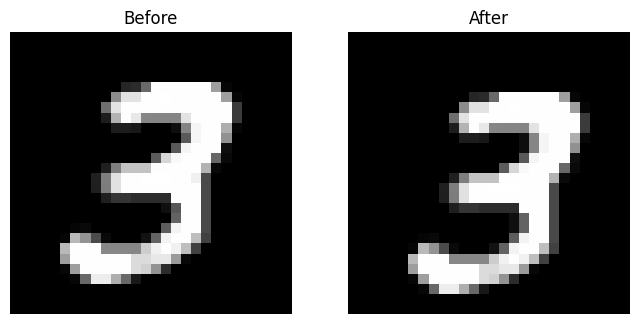

In [15]:
# pixel lato finestra
w = 2

# creo finestra
kernel = np.ones((w,w),np.uint8)

plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.imshow(img, cmap = 'gray')
plt.title("Before")
plt.axis('off')

# rimuovo buchi
img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

plt.subplot(1,2,2)
plt.imshow(img, cmap = 'gray')
plt.title("After")
plt.axis('off')
plt.show()

In [23]:
# creo funzione 'hole_removal' che applica il filtro di rimozione buchi
def hole_removal(img, w):
    # creo finestra
    kernel = np.ones((w,w),np.uint8)
    # rimuovo buchi
    oimg = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    return oimg

### Thickening

Lo strumento vincente sembra erosion di OpenCV ([leggi qui](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html#erosion))

La sintassi è:

```python
img = cv2.imread('j.png',0)
kernel = np.ones((5,5),np.uint8)
erosion = cv2.erode(img,kernel,iterations = 1)
```

#### Riferimenti
-  https://stackoverflow.com/questions/56601130/how-to-reduce-the-thickness-of-the-contours
-  https://stackoverflow.com/questions/51133962/how-can-i-scale-a-thickness-of-a-character-in-image-using-python-opencv

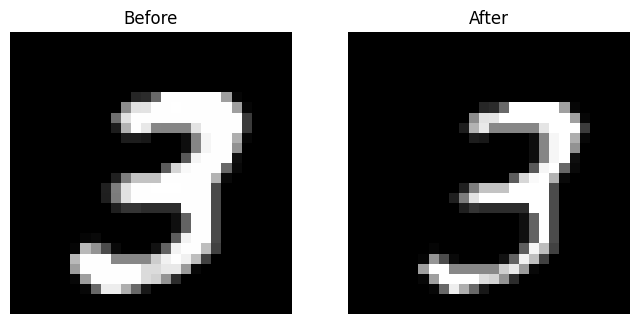

In [16]:
# plot before
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.imshow(img, cmap = 'gray')
plt.title("Before")
plt.axis('off')

# riduco spessore
erosion = cv2.erode(img,kernel,iterations = 1)

# plot after
plt.subplot(1,2,2)
plt.imshow(erosion, cmap = 'gray')
plt.title("After")
plt.axis('off')

# sovrascrivo immagine
img = erosion

In [17]:
# creo funzione 'thickness_reduction' che riduce lo spessore
def thickness_reduction(img, w, n_iterations):
    # creo finestra
    kernel = np.ones((w,w),np.uint8)
    # riduco spessore
    oimg = cv2.erode(img,kernel,iterations = n_iterations)
    return oimg

### Binarizing

Esistono varie tecniche ([vedi qui](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html))

```python
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,11,2)
```

se non funzinoa, possiamo provare il metodo di Otzu:
```python
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
```

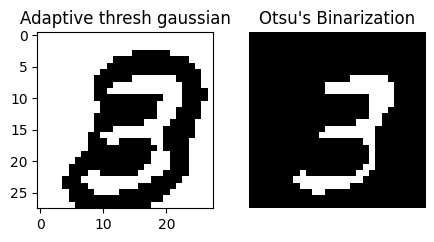

In [18]:
# adaptive thresh gaussian
atg = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,6)

# otsu
ret,ots = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# plotting results
plt.figure(figsize=(5, 3))
plt.subplot(1,2,1)
plt.title("Adaptive thresh gaussian")
plt.imshow(atg, cmap = 'gray')
plt.subplot(1,2,2)
plt.title("Otsu's Binarization")
plt.imshow(ots, cmap = 'gray')
plt.axis('off')
plt.show()

In [19]:
# scelgo metodo
img = ots

In [20]:
# creo funzione 'binarization' che applica il filtro di binarizzazione
def binarization(img):
    ret,oimg = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return oimg

### Resizing

focus to content

Riferimenti:
- https://stackoverflow.com/questions/74089678/remove-whitespace-of-a-image-python-opencv

Non funziona


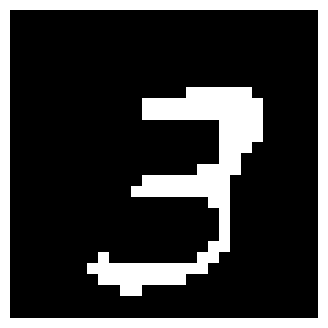

In [24]:
# define function
def focus_to_content(img):
    img_ = 255*(img < 128).astype(np.uint8) 
    coords = cv2.findNonZero(img_) # Find all non-zero points (text)
    x, y, w, h = cv2.boundingRect(coords) # Find minimum spanning bounding box
    
    rect = img[y:y+h, x:x+w] # Crop the image - note we do this on the original image
    rect_originalSized = cv2.resize(rect,(img.shape))
    return rect_originalSized

# apply function
test = focus_to_content(img)

# show
print("Non funziona")
show_image(test)

### Operazioni sull'array

Applico le operazioni precedenti a tutto l'array di training e test

In [25]:
# applica le operazioni di preprocessing (noise reduction, fix holes, thinning, binatization) a tutto l'array di training

# lista le funzioni create
functions = [noise_removal, hole_removal, thickness_reduction, binarization]

# inizializza array x_train_processed lungo come x_train
x_train_processed = np.zeros_like(x_train)

# inizializza array x_test_processed lungo come x_test
x_test_processed = np.zeros_like(x_test)

# per ogni elemento dell'array di training applica le funzioni
for i in range(len(x_train)):
    x_train_processed[i] = noise_removal(x_train[i], 3)
    x_train_processed[i] = hole_removal(x_train_processed[i], 2)
    x_train_processed[i] = thickness_reduction(x_train_processed[i], 2, 1)
    # x_train_processed[i] = binarization(x_train_processed[i])

# applica le operazioni di preprocessing (noise reduction, fix holes, thinning, focus to content) a tutto l'array di test
for i in range(len(x_test)):
    x_test_processed[i] = noise_removal(x_test[i], 3)
    x_test_processed[i] = hole_removal(x_test_processed[i], 2)
    x_test_processed[i] = thickness_reduction(x_test_processed[i], 2, 1)
    # x_test_processed[i] = binarization(x_test_processed[i])

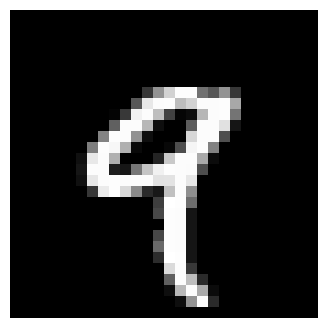

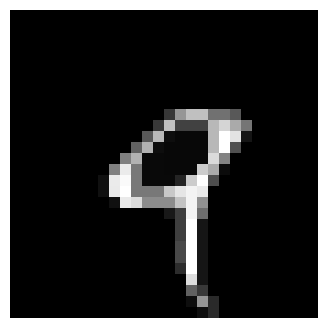

In [26]:
# preview
n = 4
show_image(x_train[n])
show_image(x_train_processed[n])

## Modello con dati preprocessati

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 100)               78500     
                                                                 
 dense_4 (Dense)             (None, 2)                 202       
                                                                 
 dense_5 (Dense)             (None, 10)                30        
                                                                 
Total params: 78,732
Trainable params: 78,732
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1875/1875 [==============================] - 4s 2ms/step - loss: 1.4209 - accuracy: 0.4653 - val_loss: 1.1081 - val_accuracy: 0.6294
Epoch 2/15
1875/1875 [================

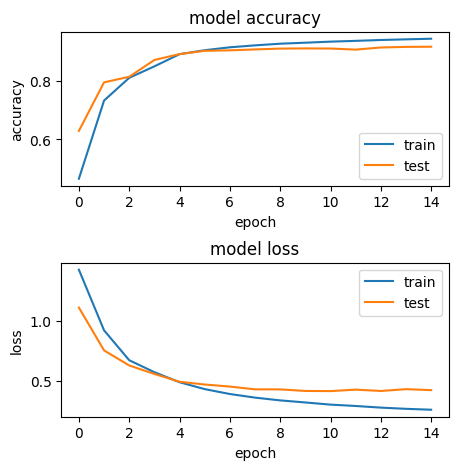

In [27]:
# invoco funzione recognize_digit con parametri (shape, n_epochs, n_categories, x_train, y_train, x_test, y_test, path):
history2 = recognize_digit(28, 15, 10, x_train_processed, y_train, x_test_processed, y_test, '4_mnist/models/pp.mnist.model.h5')

# visualizza la loss e l'accuracy del modello
plot_results(history2)

In [28]:
pd.DataFrame(history2.history)

,loss,accuracy,val_loss,val_accuracy
0,1.420930,0.465267,1.108095,0.6294
1,0.920008,0.733367,0.754190,0.7958
2,0.672934,0.811367,0.629487,0.8149
3,0.573963,0.850650,0.559602,0.8725
4,0.491103,0.892433,0.494888,0.8927
5,0.434155,0.906033,0.472050,0.9040
6,0.393690,0.916033,0.455224,0.9056
7,0.363861,0.922650,0.432195,0.9087
8,0.340995,0.928367,0.431947,0.9116
9,0.323801,0.931817,0.419057,0.9122


1/1 [==============================] - 0s 51ms/step


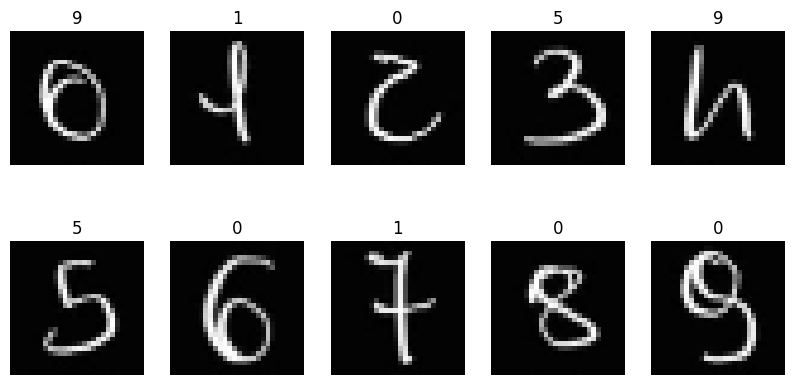

In [29]:
# applico modello alle mie immagini invocando la funzione personal_digit_recognizer(cartella_immagini, nuova_dimensione, model_path)
personal_digit_recognizer(cartella_immagini, nuova_dimensione, '4_mnist/models/pp.mnist.model.h5')